In [1]:
import numpy as np
import os
import arc
import importlib
importlib.reload(arc)
import json
import pandas as pd
import pickle


shelf_name='brunt-riiser-ekstrom'

# atl06_file_name = './atl06_' + shelf_name + '.pkl'
# atl06_file_name = '/home/bradlipovsky/notebooks/brunt-is2-rifts/atl06_' + shelf_name + '.pkl'
atl06_file_name = '/data/fast1/arc/atl06_' + shelf_name + '.pkl'
# atl06_filelist = './filelists/' + shelf_name + '-list.json'
# dataset_path = '/data/fast0/'


# Load data (deserialize)
with open(atl06_file_name, 'rb') as handle:
    atl06_data = pickle.load(handle)
    print('ATL06 data loaded from pickle.')

# ATL06 quality flags 0: No problem 1: Problem    

display(atl06_data.loc[40])

#lat = row["lat"]
#lon = row["lon"]
#print(len(lon))
#print(lon[1])
#print(lat[1])
#print(lon[len(lon)-1])
#print(lat[len(lat)-1])




ATL06 data loaded from pickle.


x          [-454024.67383270594, -454032.82386449946, -45...
y          [1787260.0657539228, 1787277.5525110685, 17872...
x_atc      [31983231.04154289, 31983250.946893923, 319832...
h          [92.744896, 92.64545, 92.68037, 92.66612, 92.6...
lat        [-73.14588208776458, -73.14571123225751, -73.1...
lon        [-14.253566856774114, -14.253678514241784, -14...
azimuth    [-8.071938, -8.071874, -8.071811, -8.071748, -...
quality    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
geoid      [5.890827, 5.8919487, 5.893068, 5.8941975, 5.8...
h_sig      [0.020724637, 0.019774776, 0.01896736, 0.01980...
rgt                                                    565.0
time                        2018-11-04 15:53:02.276447+00:00
beam                                                      3r
tides      [--, --, --, --, --, --, --, --, --, --, --, -...
Name: 40, dtype: object

[(3878, 3889), (4562, 4563)]


(0.0, 100.0)

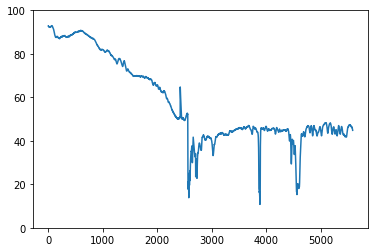

In [2]:
# for i, row in atl06_data.iterrows():
row = atl06_data.iloc[40] #40 is the trace used in other notebook

#display(row)

# arc.find_the_rifts line 262
# arc.get_rifts 350
rift_list = arc.find_the_rifts(row["h"] - row["geoid"]- row["tides"])
#rift_list = arc.find_the_rifts(row['h'])

print(rift_list)

import matplotlib.pyplot as plt
plt.plot(row['h'])
plt.ylim((0,100))

rift detector found 2 rifts
(3878, 3889)
(4562, 4563)


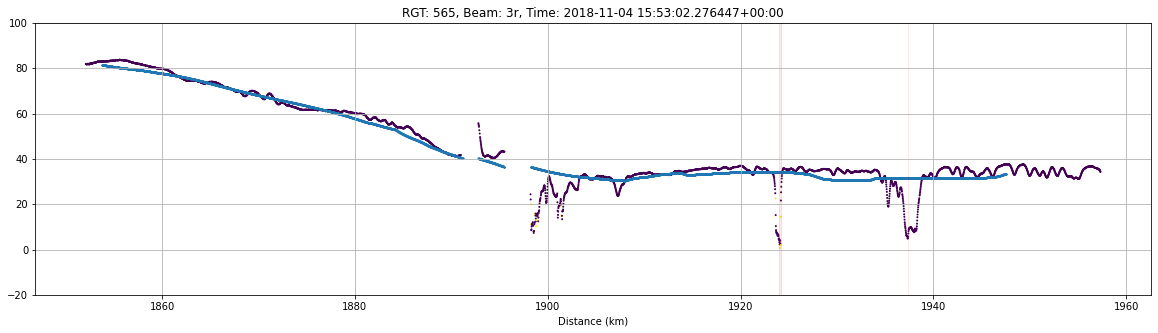

In [3]:
# plot to look like QC

from matplotlib.patches import Rectangle

fig,ax=plt.subplots(figsize=(20,5))

d = np.sqrt(row["x"]**2 + row["y"]**2) / 1000 #distance in km
h = row["h"] - row["geoid"]- row["tides"]

#uncomment these two lines to filter out quality == 1 flags
#but removing them stops the simple running mean from working properly
#h_qual = row["quality"]
#h_filt = np.where(h_qual == 1, np.NaN, h)

# make a rolling average
# May want to exclude quality flag 1
# or do we exclude things with large jumps? (>200m?)
# platelet is 40m, half overlapping
# 1km either side (2km) = 100, 10 km (20km) 1000 etc

# could use something more advanced

# Potential problem here is going to be the ends
# near grounding line and calving front that are cut off
# and get larger as the smoothing distance increases

def running_mean(x,N):
    cumsum = np.cumsum(np.insert(x,0,0))
    return(cumsum[N:] - cumsum[:-N]) / float(N)

run_length = 1000
h_run = running_mean(h,run_length+1)
d_run = d[int(run_length/2):int(len(d)-(run_length/2))]

#plt.scatter(d,row["h"],c=row["quality"])
plt.scatter(d,h,s=1,c=row["quality"])
plt.scatter(d_run,h_run,s=1)
#plt.scatter(d,h_run_nan)

plt.title('RGT: %i, Beam: %s, Time: %s'%(row["rgt"],row["beam"],row["time"]))
plt.xlabel('Distance (km)')

plot_min = -20
plot_max = 100

nr_rifts = len(rift_list)
print("rift detector found " + str(nr_rifts) + " rifts")

for rift in rift_list:
    print(rift)
    rift_start = rift[0]
    rift_end   = rift[1]
    dist_start = d[rift_start]
    dist_end   = d[rift_end]
    dist_rift  = dist_end - dist_start
    ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
                edgecolor = 'red',
                facecolor = 'red',
                alpha = 0.1))

plt.ylim((plot_min,plot_max))
#plt.xlim(1900,1910)
plt.grid()
plt.show()

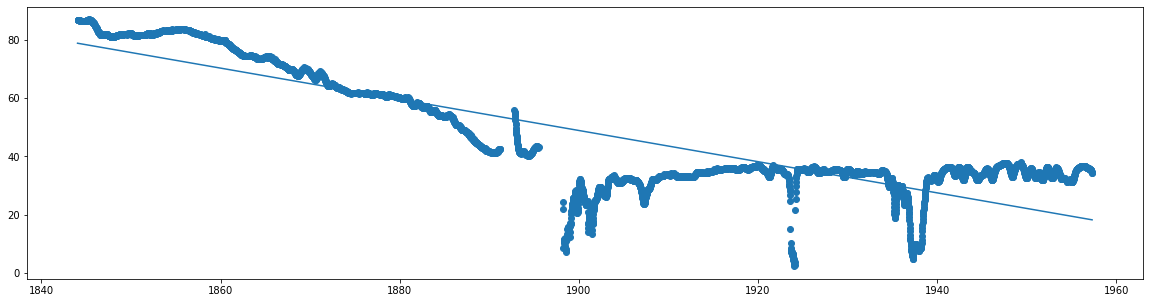

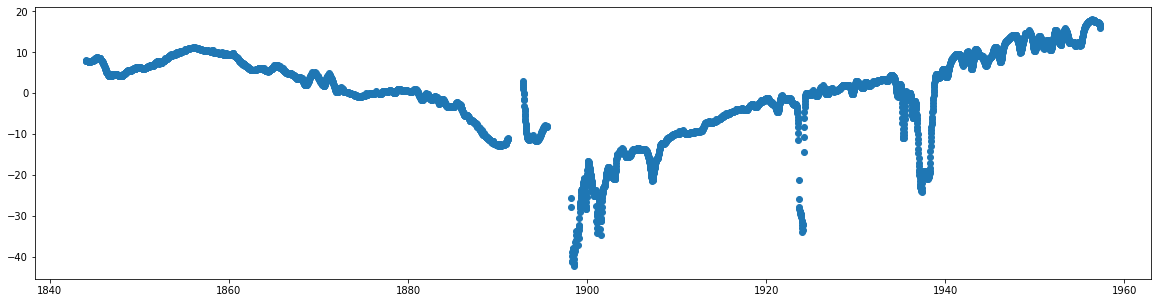

In [4]:
from sklearn.linear_model import LinearRegression

# lets try removing the bad values
# ie flagged as 1 by ATL06 processor

h_qual = row["quality"]
h_filt = np.where(h_qual == 1, np.NaN, h)
#print(len(h_qual))
d_test = d[~np.isnan(h_filt)]
h_test = h_filt[~np.isnan(h_filt)]
#print(len(h_test))
#print(len(d_test))

h_test = h_test.reshape(-1,1)
d_test = d_test.reshape(-1,1)

model = LinearRegression().fit(d_test,h_test)

trend = model.predict(d_test)

fig,ax=plt.subplots(figsize=(20,5))
plt.scatter(d_test,h_test)
plt.plot(d_test,trend)
plt.show()

h_detrend = [h_test[j]-trend[j] for j in range(0, len(h_test))]

fig,ax=plt.subplots(figsize=(20,5))
plt.scatter(d_test,h_detrend)
plt.show()

# but removing the flagged points makes gaps
# maybe a problem if clustered together

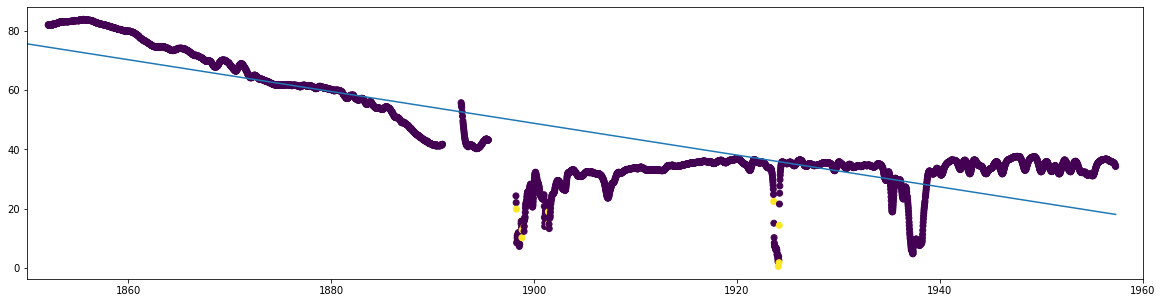

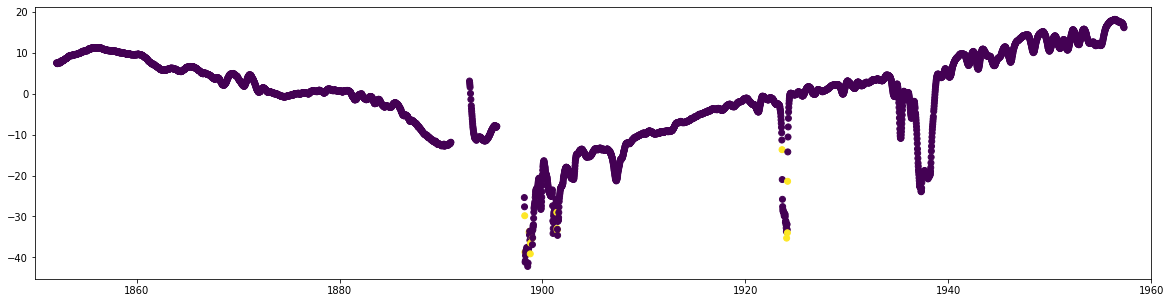

In [5]:
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.signal import butter, filtfilt

h_4lr = h.reshape(-1,1)
d_4lr = d.reshape(-1,1)

model = LinearRegression().fit(d_4lr,h_4lr)

trend = model.predict(d_4lr)

fig,ax=plt.subplots(figsize=(20,5))
plt.scatter(d_4lr,h_4lr,c=row["quality"])
plt.plot(d_4lr,trend)
plt.xlim(1850,1960)
plt.show()

h_detrend = [h_4lr[j]-trend[j] for j in range(0, len(h_4lr))]

fig,ax=plt.subplots(figsize=(20,5))
plt.scatter(d_4lr,h_detrend,c=row["quality"])
plt.xlim(1850,1960)
plt.show()

# and now try a low pass filter

#fig,ax=plt.subplots(figsize=(20,5))
#plt.scatter(d_4lr,h_lowpass,c=row["quality"])
#plt.xlim(1850,1960)
#plt.show()    

Zoom in on the detected rifts

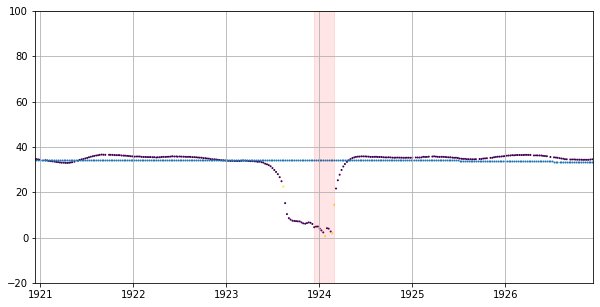

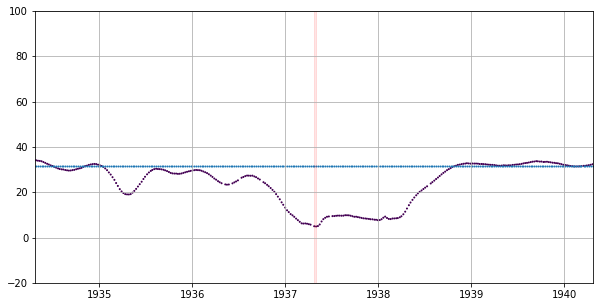

h     5586
d     5586
h_run 4586
d_run 4586


In [5]:
from matplotlib.patches import Rectangle

# make plot zoomed in on each rift (up to max_plots)
dist_around_rift = 3 #km
max_plots = 3
if len(rift_list) < max_plots:
    max_plots = len(rift_list)

# loop through plotting approx. 3 km either side of detected rift

plot_min = -20
plot_max = 100

i=0 #initialise
for rift in rift_list:
    i += 1
    if i > max_plots:
        break
    fig,ax=plt.subplots(figsize=(10,5))
    plt.scatter(d,h,s=1,c=row["quality"])
    plt.scatter(d_run,h_run,s=1)
    rift_start = rift[0]
    rift_end   = rift[1]
    dist_start = d[rift_start]
    dist_end   = d[rift_end]
    dist_rift  = dist_end - dist_start
    ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
                edgecolor = 'red',
                facecolor = 'red',
                alpha = 0.1))

    plt.ylim(plot_min,plot_max)
    plt.xlim(dist_start-3,dist_start+3)
    plt.grid()
    plt.show()
    
print('h     ' + str(len(h))) 
print('d     ' + str(len(d)))
print('h_run ' + str(len(h_run)))
print('d_run ' + str(len(d_run)))

#first rift (3878,3889)
#second rift (4562, 4563)    

Zoom in on detected rift


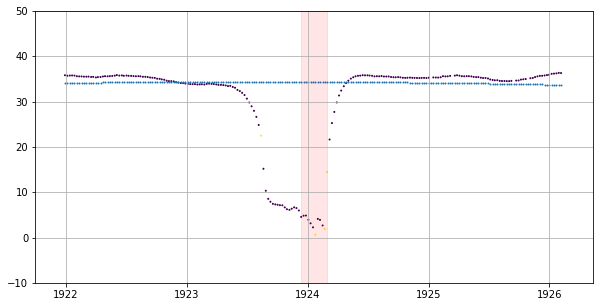

plot the theta/slope difference and h difference
manually define the rift extent (for now) 


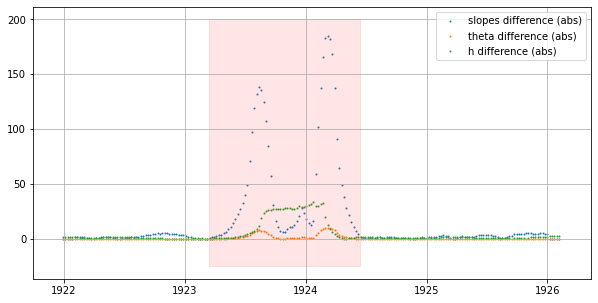

show manually defined extent on zoomed in rift plot


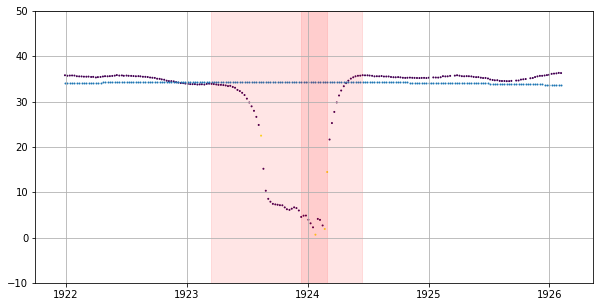

plot the angles


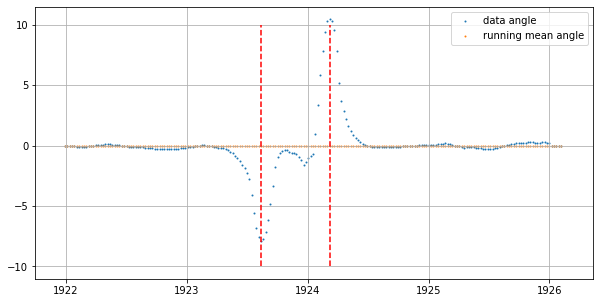

now see how this looks on the rift


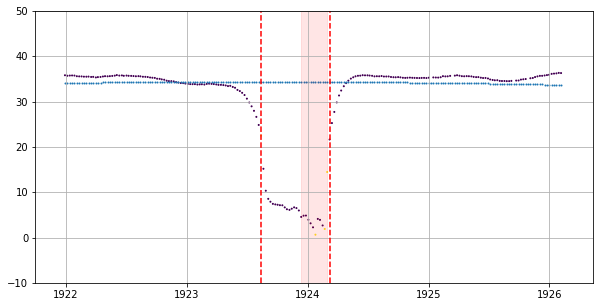

rift width is 0.57 km
rift width measure locations - min: 83 max: 112
full walls estimated locations - min: 63 max: 127


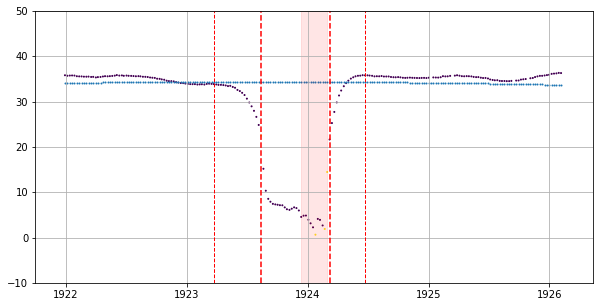

elevation upglacier  : 33.87 m
elevation downglacier: 35.8 m


In [117]:
# the running mean will always (?) be lower than the rift edges
# because of the below average points in the rift dragging down
# the average value 
#
# take a segment either side of the detection
# several km larger than the rift 
# but below rift separation
# is this possible?
#
# idea 1:
# calculate average offset between the rift and running mean
# take out large values (ie in the rift)
# use to move the average surface upwards
# rift edge is where the two meet.
#
# probably not that robust
#
# idea 2:
# running linear regression of data and surface
# rift edge where they agree to within a certain tolerance
# and probably some h difference
# to avoid identifying flat melange as ice shelf surface

#first rift (3878,3889)
#2km around detected rift
#1=20m, 100=2000m

#from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from matplotlib.patches import Rectangle
import math

h_sub = h[3778:3989]
d_sub = d[3778:3989]
q = row["quality"]
q_sub = q[3778:3989]
h_run_sub = h_run[3278:3489]
d_run_sub = d_run[3278:3489]

print("Zoom in on detected rift")

fig,ax=plt.subplots(figsize=(10,5))
plt.scatter(d_sub,h_sub,s=1,c=q_sub)
plt.scatter(d_run_sub,h_run_sub,s=1)
rift = rift_list[0] #first rift detected, the simple one!
rift_start = rift[0]
rift_end   = rift[1]
dist_start = d[rift_start]
dist_end   = d[rift_end]
dist_rift  = dist_end - dist_start
ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
            edgecolor = 'red',
            facecolor = 'red',
            alpha = 0.1))

plot_min = -10
plot_max = 50

plt.ylim(plot_min,plot_max)
plt.xlim(dist_start-2.2,dist_end+2.2)
plt.grid()
plt.show()

# linear regression and average h
# through h and h_run

#def running_mean(x,N):
#    cumsum = np.cumsum(np.insert(x,0,0))
#    return(cumsum[N:] - cumsum[:-N]) / float(N)

#run_length = 10
#h_test = running_mean(h_run_sub,run_length+1)

#print(len(h_run_sub))
#print(len(h_test))

#test = np.cumsum(np.insert(h_run_sub,0,0))
#print(test)
h_11 = h_run_sub[0:11]
d_11 = d_run_sub[0:11]
#print(h_11)
#print(len(h_11))
#print(h_run_sub)

#h_11 = h_11.reshape(-1,1)
#d_11 = d_11.reshape(-1,1)

sl_11 = linregress(d_11,h_11).slope

#print(d_11)
#print(h_11)
#print(sl_11)
#model = LinearRegression().fit(d_11,h_11)

#trend = model.predict(d_11)

#print(model)
#print(trend)
slopes_run  = np.zeros(len(h_run_sub))
slopes_data = np.zeros(len(h_sub))
thetas_run  = np.zeros(len(h_run_sub))
thetas_data = np.zeros(len(h_sub))

#211 samples 11 filter, 5 either side so -10
for i in range (5,len(h_run_sub)-5): #(5,6):
    #print(i)
    h_11 = h_run_sub[i-5:i+6]
    d_11 = d_run_sub[i-5:i+6]
    slopes_run[i]=linregress(d_11,h_11).slope
    
    #0 to 180
    #y=mx+c
    slope_run = linregress(d_11,h_11).slope
    inter_run = linregress(d_11,h_11).intercept
    yrun1 = (slope_run * d_11[0]) + inter_run
    yrun2 = (slope_run * d_11[10]) + inter_run
    
    thetas_run[i]= math.degrees(math.atan((yrun2-yrun1)/((d_11[10]-d_11[0])*1000)))
    
    #print(yrun2)
    #print(yrun1)
    #print(yrun2-yrun1)
    #print((d_11[10]-d_11[0])/1000)
    #print(d_11[10])
    #print(d_11[0])
    
    hd_11 = h_sub[i-5:i+6]
    dd_11 = d_sub[i-5:i+6]
    slopes_data[i]=linregress(dd_11,hd_11).slope
    
    slope_data = linregress(dd_11,hd_11).slope
    inter_data = linregress(dd_11,hd_11).intercept
    ydata1 = (slope_data * dd_11[0]) + inter_data
    ydata2 = (slope_data * dd_11[10]) + inter_data
    
    thetas_data[i]= math.degrees(math.atan((ydata2-ydata1)/((dd_11[10]-dd_11[0])*1000)))
    
    

#print(slopes_run)
#print(slopes_data)
    
slopes_diff = abs(slopes_run - slopes_data)
thetas_diff = abs(thetas_run - thetas_data)
h_diff = abs(h_run_sub - h_sub)

print("plot the theta/slope difference and h difference")
print("manually define the rift extent (for now) ")

fig,ax=plt.subplots(figsize=(10,5))
plt.scatter(d_sub,slopes_diff,s=1)
plt.scatter(d_sub,thetas_diff,s=1)
plt.scatter(d_sub,h_diff,s=1)
plt.legend(["slopes difference (abs)", "theta difference (abs)", "h difference (abs)"])
#plt.ylim(plot_min,plot_max)
plt.xlim(dist_start-2.2,dist_end+2.2)

#do this by eye
ax.add_patch(Rectangle((1923.2,-25),1.25,225,
            edgecolor = 'red',
            facecolor = 'red',
            alpha = 0.1))

plt.grid()
plt.show()

print("show manually defined extent on zoomed in rift plot")

# try this on the original plot
fig,ax=plt.subplots(figsize=(10,5))
plt.scatter(d_sub,h_sub,s=1,c=q_sub)
plt.scatter(d_run_sub,h_run_sub,s=1)
rift = rift_list[0] #first rift detected, the simple one!
rift_start = rift[0]
rift_end   = rift[1]
dist_start = d[rift_start]
dist_end   = d[rift_end]
dist_rift  = dist_end - dist_start
ax.add_patch(Rectangle((1923.2,-25),1.25,225,
            edgecolor = 'red',
            facecolor = 'red',
            alpha = 0.1))

ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
            edgecolor = 'red',
            facecolor = 'red',
            alpha = 0.1))

plot_min = -10
plot_max = 50

plt.ylim(plot_min,plot_max)
plt.xlim(dist_start-2.2,dist_end+2.2)
plt.grid()
plt.show()

# so rift edge where h diff and slope diff are close to 0
# what is the rift width?
# full width at half maximum?
# separation of 2 peaks of maximum slope difference?
# (ie the separation of the most vertical parts of the rift?
#print(thetas_run)
#print(thetas_data)
#print(thetas_diff)

thetas_max_pos_km = d_run_sub[np.argmax(thetas_data)]
thetas_min_pos_km = d_run_sub[np.argmin(thetas_data)]


print("plot the angles")

fig,ax=plt.subplots(figsize=(10,5))
plt.scatter(d_sub,thetas_data,s=1)
plt.scatter(d_run_sub,thetas_run,s=1)
#plt.scatter(d_run_sub,thetas_diff,s=1)
#plt.legend(["data angle", "running mean angle", "angle difference (abs)"])
plt.legend(["data angle", "running mean angle"])
plt.plot([thetas_max_pos_km,thetas_max_pos_km],[-10, 10], color = 'r', linestyle = '--')
plt.plot([thetas_min_pos_km,thetas_min_pos_km],[-10, 10], color = 'r', linestyle = '--')
plt.xlim(dist_start-2.2,dist_end+2.2)
plt.grid()
plt.show()

print("now see how this looks on the rift")

fig,ax=plt.subplots(figsize=(10,5))
plt.scatter(d_sub,h_sub,s=1,c=q_sub)
plt.scatter(d_run_sub,h_run_sub,s=1)
rift = rift_list[0] #first rift detected, the simple one!
rift_start = rift[0]
rift_end   = rift[1]
dist_start = d[rift_start]
dist_end   = d[rift_end]
dist_rift  = dist_end - dist_start
ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
            edgecolor = 'red',
            facecolor = 'red',
            alpha = 0.1))

plt.plot([thetas_max_pos_km,thetas_max_pos_km],[-10, 50], color = 'r', linestyle = '--')
plt.plot([thetas_min_pos_km,thetas_min_pos_km],[-10, 50], color = 'r', linestyle = '--')

plot_min = -10
plot_max = 50

plt.ylim(plot_min,plot_max)
plt.xlim(dist_start-2.2,dist_end+2.2)
plt.grid()
plt.show()

rift_width = thetas_max_pos_km - thetas_min_pos_km
print("rift width is "+str(round(rift_width,2))+" km")

thetas_max_pos = np.argmax(thetas_data)
thetas_min_pos = np.argmin(thetas_data)

print("rift width measure locations - min: "+str(thetas_min_pos)+" max: "+str(thetas_max_pos))

thetas_diff_threshold = 0.1 #1

thetas_true = np.where(thetas_diff < thetas_diff_threshold)
thetas_diff_below_before = max(t for t in thetas_true[0] if t < thetas_min_pos)
thetas_diff_below_after = min(t for t in thetas_true[0] if t > thetas_max_pos)
print("full walls estimated locations - min: "+str(thetas_diff_below_before)+" max: "+str(thetas_diff_below_after))

thetas_min_wall_pos_km = d_run_sub[thetas_diff_below_before]
thetas_max_wall_pos_km = d_run_sub[thetas_diff_below_after]

fig,ax=plt.subplots(figsize=(10,5))
plt.scatter(d_sub,h_sub,s=1,c=q_sub)
plt.scatter(d_run_sub,h_run_sub,s=1)
rift = rift_list[0] #first rift detected, the simple one!
rift_start = rift[0]
rift_end   = rift[1]
dist_start = d[rift_start]
dist_end   = d[rift_end]
dist_rift  = dist_end - dist_start
ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
            edgecolor = 'red',
            facecolor = 'red',
            alpha = 0.1))

plt.plot([thetas_max_pos_km,thetas_max_pos_km],[-10, 50], color = 'r', linestyle = '--')
plt.plot([thetas_min_pos_km,thetas_min_pos_km],[-10, 50], color = 'r', linestyle = '--')
plt.plot([thetas_min_wall_pos_km,thetas_min_wall_pos_km],[-10, 50], color = 'r', linestyle = '--', linewidth = 1.0)
plt.plot([thetas_max_wall_pos_km,thetas_max_wall_pos_km],[-10, 50], color = 'r', linestyle = '--', linewidth = 1.0)

plot_min = -10
plot_max = 50

plt.ylim(plot_min,plot_max)
plt.xlim(dist_start-2.2,dist_end+2.2)
plt.grid()
plt.show()

print("elevation upglacier  : "+str(round(h_sub[thetas_diff_below_before],2))+" m")
print("elevation downglacier: "+str(round(h_sub[thetas_diff_below_after],2))+" m")


rift width is 1.37 km
rift width measure locations - min: 82 max: 152
full walls estimated locations - min: 64 max: 185


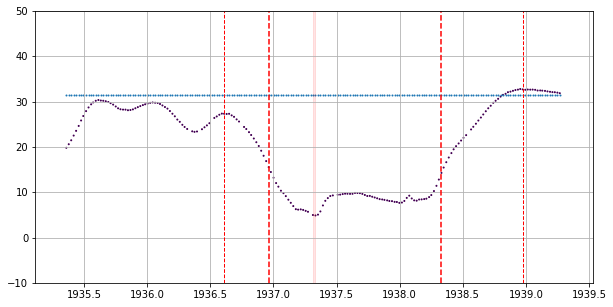

elevation upglacier  : 27.31 m
elevation downglacier: 32.69 m


In [118]:
#first rift (3878,3889)
#second rift (4562, 4563) 

from scipy.stats import linregress
from matplotlib.patches import Rectangle
import math

rift = rift_list[1]

h_sub = h[rift[0]-100:rift[1]+100]
d_sub = d[rift[0]-100:rift[1]+100]
q = row["quality"]
q_sub = q[rift[0]-100:rift[1]+100]
h_run_sub = h_run[rift[0]-100-500:rift[1]+100-500]
d_run_sub = d_run[rift[0]-100-500:rift[1]+100-500]

slopes_run  = np.zeros(len(h_run_sub))
slopes_data = np.zeros(len(h_sub))
thetas_run  = np.zeros(len(h_run_sub))
thetas_data = np.zeros(len(h_sub))

#211 samples 11 filter, 5 either side so -10
for i in range (5,len(h_run_sub)-5): #(5,6):
    #print(i)
    h_11 = h_run_sub[i-5:i+6]
    d_11 = d_run_sub[i-5:i+6]
    slopes_run[i]=linregress(d_11,h_11).slope
    
    #0 to 180
    #y=mx+c
    slope_run = linregress(d_11,h_11).slope
    inter_run = linregress(d_11,h_11).intercept
    yrun1 = (slope_run * d_11[0]) + inter_run
    yrun2 = (slope_run * d_11[10]) + inter_run
    
    thetas_run[i]= math.degrees(math.atan((yrun2-yrun1)/((d_11[10]-d_11[0])*1000)))
    
    hd_11 = h_sub[i-5:i+6]
    dd_11 = d_sub[i-5:i+6]
    slopes_data[i]=linregress(dd_11,hd_11).slope
    
    slope_data = linregress(dd_11,hd_11).slope
    inter_data = linregress(dd_11,hd_11).intercept
    ydata1 = (slope_data * dd_11[0]) + inter_data
    ydata2 = (slope_data * dd_11[10]) + inter_data
    
    thetas_data[i]= math.degrees(math.atan((ydata2-ydata1)/((dd_11[10]-dd_11[0])*1000)))
    
slopes_diff = abs(slopes_run - slopes_data)
thetas_diff = abs(thetas_run - thetas_data)
h_diff = abs(h_run_sub - h_sub)

thetas_max_pos_km = d_run_sub[np.argmax(thetas_data)]
thetas_min_pos_km = d_run_sub[np.argmin(thetas_data)]
    
rift_width = thetas_max_pos_km - thetas_min_pos_km
print("rift width is "+str(round(rift_width,2))+" km")

thetas_max_pos = np.argmax(thetas_data)
thetas_min_pos = np.argmin(thetas_data)

print("rift width measure locations - min: "+str(thetas_min_pos)+" max: "+str(thetas_max_pos))

thetas_diff_threshold = 0.1 #1

thetas_true = np.where(thetas_diff < thetas_diff_threshold)
thetas_diff_below_before = max(t for t in thetas_true[0] if t < thetas_min_pos)
thetas_diff_below_after = min(t for t in thetas_true[0] if t > thetas_max_pos)
print("full walls estimated locations - min: "+str(thetas_diff_below_before)+" max: "+str(thetas_diff_below_after))

thetas_min_wall_pos_km = d_run_sub[thetas_diff_below_before]
thetas_max_wall_pos_km = d_run_sub[thetas_diff_below_after]

fig,ax=plt.subplots(figsize=(10,5))
plt.scatter(d_sub,h_sub,s=1,c=q_sub)
plt.scatter(d_run_sub,h_run_sub,s=1)
#rift = rift_list[0] #first rift detected, the simple one!
rift_start = rift[0]
rift_end   = rift[1]
dist_start = d[rift_start]
dist_end   = d[rift_end]
dist_rift  = dist_end - dist_start
ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
            edgecolor = 'red',
            facecolor = 'red',
            alpha = 0.1))

plt.plot([thetas_max_pos_km,thetas_max_pos_km],[-10, 50], color = 'r', linestyle = '--')
plt.plot([thetas_min_pos_km,thetas_min_pos_km],[-10, 50], color = 'r', linestyle = '--')
plt.plot([thetas_min_wall_pos_km,thetas_min_wall_pos_km],[-10, 50], color = 'r', linestyle = '--', linewidth = 1.0)
plt.plot([thetas_max_wall_pos_km,thetas_max_wall_pos_km],[-10, 50], color = 'r', linestyle = '--', linewidth = 1.0)

plot_min = -10
plot_max = 50

plt.ylim(plot_min,plot_max)
plt.xlim(dist_start-2.2,dist_end+2.2)
plt.grid()
plt.show()

print("elevation upglacier  : "+str(round(h_sub[thetas_diff_below_before],2))+" m")
print("elevation downglacier: "+str(round(h_sub[thetas_diff_below_after],2))+" m")

# second (more complex) rift upglacier wall is maybe peak just after 1936 km
# could place additional condition on h difference?
